# Task4 建模调参

## 4.0.0 建模调参介绍
1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

## 4.0.1 模型原理
### 1. 线性回归模型

https://zhuanlan.zhihu.com/p/49480391

### 2. 决策树模型

https://zhuanlan.zhihu.com/p/65304798

### 3. GBDT模型

https://zhuanlan.zhihu.com/p/45145899

### 4. XGBoost模型

https://zhuanlan.zhihu.com/p/86816771

### 5. LightGBM模型

https://zhuanlan.zhihu.com/p/89360721

### 6. 推荐教材：

   - 《机器学习》 https://book.douban.com/subject/26708119/
   - 《统计学习方法》 https://book.douban.com/subject/10590856/
   - 《Python大战机器学习》 https://book.douban.com/subject/26987890/
   - 《面向机器学习的特征工程》 https://book.douban.com/subject/26826639/
   - 《数据科学家访谈录》 https://book.douban.com/subject/30129410/


## 4.1 读取数据
reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [5]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [9]:
continuous_feature_names

['SaleID',
 'name',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'notRepairedDamage',
 'seller',
 'offerType',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'train',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin']

## 4.2 线性回归 & 五折交叉验证 & 模拟真实业务情况

In [6]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

### 4.2.1 简单建模

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
model = LinearRegression(normalize=True)

In [10]:
model = model.fit(train_X, train_y)

In [11]:
# 查看训练的线性回归模型的截距（intercept）与权重(coef)
'intercept:'+ str(model.intercept_)

'intercept:-110670.68277263983'

In [12]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416419197),
 ('v_8', 700675.5609399268),
 ('v_9', 170630.27723222988),
 ('v_7', 32322.6619320463),
 ('v_12', 20473.67079698017),
 ('v_3', 17868.079541503772),
 ('v_11', 11474.93899672877),
 ('v_13', 11261.76456001673),
 ('v_10', 2683.9200905880143),
 ('gearbox', 881.82250392483),
 ('fuelType', 363.90425072141386),
 ('bodyType', 189.60271012070356),
 ('city', 44.94975120522533),
 ('power', 28.553901616756647),
 ('brand_price_median', 0.5103728134078772),
 ('brand_price_std', 0.45036347092629514),
 ('brand_amount', 0.1488112039506631),
 ('brand_price_max', 0.0031910186703130684),
 ('SaleID', 5.35598991985537e-05),
 ('offerType', 5.613313987851143e-06),
 ('train', 3.03611159324646e-07),
 ('seller', -3.169756382703781e-06),
 ('brand_price_sum', -2.1750068681877673e-05),
 ('name', -0.00029800127130687816),
 ('used_time', -0.002515894332856363),
 ('brand_price_average', -0.40490484510109276),
 ('brand_price_min', -2.2467753486899187),
 ('power_bin', -34.420644117301165),
 (

In [13]:
from matplotlib import pyplot as plt

In [14]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

The predicted price is obvious different from true price


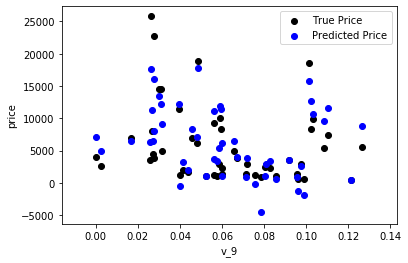

In [15]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客：https://blog.csdn.net/Noob_daniel/article/details/76087829

It is clear to see the price shows a typical exponential distribution


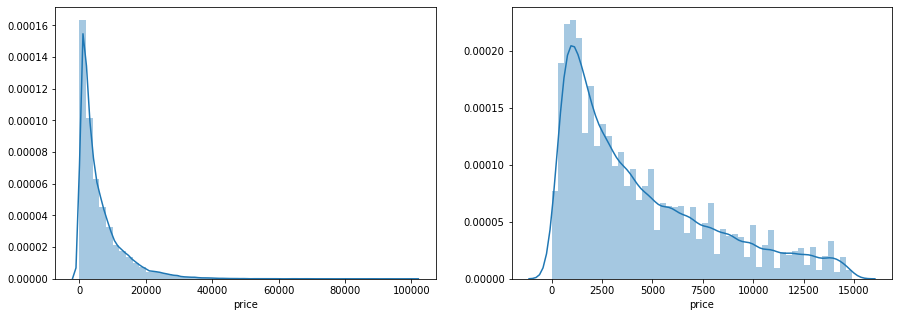

In [16]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了 $log(x+1)$ 变换，使标签贴近于正态分布


In [17]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


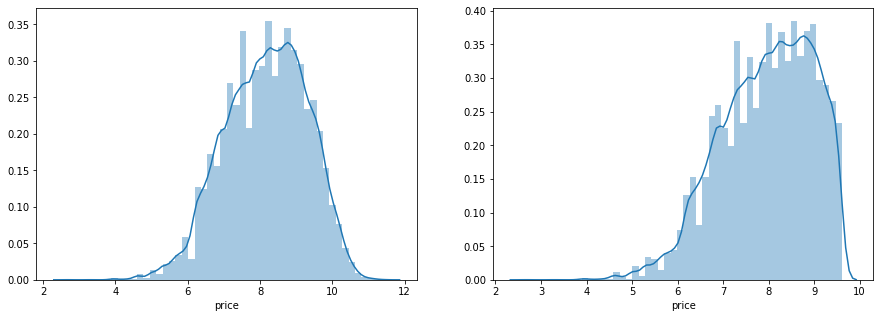

In [18]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [19]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750745460080623


[('v_9', 8.052411927759119),
 ('v_5', 5.76424850226548),
 ('v_12', 1.6182066744724324),
 ('v_1', 1.4798302934421477),
 ('v_11', 1.1669014496953527),
 ('v_13', 0.9404706038650921),
 ('v_7', 0.7137295307889449),
 ('v_3', 0.6837865320350459),
 ('v_0', 0.008500525238593855),
 ('power_bin', 0.008497967226210181),
 ('gearbox', 0.007922377819951879),
 ('fuelType', 0.006684768278659285),
 ('bodyType', 0.004523520659142897),
 ('power', 0.0007161896117538291),
 ('brand_price_min', 3.334353082747802e-05),
 ('brand_amount', 2.897880010254634e-06),
 ('brand_price_median', 1.2571119996612526e-06),
 ('brand_price_std', 6.659134278554148e-07),
 ('brand_price_max', 6.194957240892668e-07),
 ('brand_price_average', 5.999429489175172e-07),
 ('SaleID', 2.119416206654808e-08),
 ('train', 2.6716406864579767e-12),
 ('offerType', -6.906475391588174e-11),
 ('seller', -9.937650702340761e-11),
 ('brand_price_sum', -1.5126510445823242e-10),
 ('name', -7.015510649937735e-08),
 ('used_time', -4.1224771710599685e-06)

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


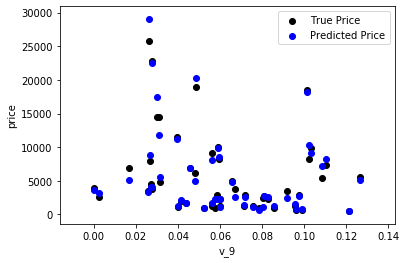

In [20]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

### 4.2.2 五折交叉验证

> 在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

> 因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [22]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [23]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）

In [24]:
print('AVG:', np.mean(scores))

AVG: 1.3658024042407904


使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）